# Agent-based model for News diffusion and misinformation

What I want to do is to create agents that share news, then from there find some interesting insights that could help fake news research

#### The first thing we need to do is to import news article and user classes

In [1]:
from classes import NewsArticle,User

1. Users attributes:  
  a. unique_id : a non-intelligent number given to the user  
  b. news_spread_chance : a percentage of the user spreading news (can be compared to confidence and censorship)   
  c. preference : the position the user feels about the current subject being discussed  
  d. user_type: the user could be a regular user or a news agency  
  e. articles : a list of articles shared by the user  
      
        
        
2. News articles attributes:  
  a. news_article_id : a non-intelligenct number given to the article  
  b. source_id : the id of the source  
  c. source_preference : the preference of the source  
  d. sentiment : a number from [1,5] or [-5,-1]  
  e. num_shares :  the number of people sharing the article  
  f. fake : 1 if the news is fake, otherwise real

#### Lets try to create a simple news article

In [2]:
x = NewsArticle(1,100,0.8,4,21,1)

In [3]:
x

News Article ID: 1
Source ID: 100
Source Preference: 0.8
Sentiment: 4
Number of shares: 21
Fake (True:1, False:0): 1

#### Now we need to try to create a few users

news_agencies_ratio is a network attribute to add that takes the amount of news agencies in the network  
number_of_users is a network attribute that creates a graph of a certain number of nodes equal to the number of users

In [4]:
from random import random, uniform, choice
from SimHelper import generate_weighted_percentage

users = []
news_agencies_ratio = 0.1
number_of_users = 100

for i in range(number_of_users):
    unique_id = i
    if random() < news_agencies_ratio:
        user_type = 'news_agency' 
    else:
        user_type = 'regular' 
        
    if user_type == 'news_agency':
        news_spread_chance = round(generate_weighted_percentage(0.8))
    else:
        news_spread_chance = round(random(),2)
    preference = round(uniform(-1,1),2)
    
    articles = []
    users.append(User(unique_id,news_spread_chance,preference,user_type,articles))

In [5]:
users[82]

User ID: 82
News Spread Chance: 0.1
Preference: 0.49
Type: regular

### Lets try to create a network of the users

In [6]:
import networkx as nx

In [7]:
G = nx.Graph()
G.add_nodes_from(users)

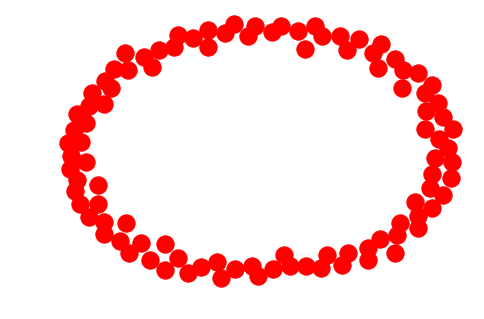

In [8]:
%matplotlib inline
nx.draw(G)

In [9]:
# G = nx.scale_free_graph(100)
# G = G.to_undirected()

In [10]:
color_map = []
for node in list(G.nodes()):
    if node.preference < -0.5:
        color_map.append('red')
    elif node.preference > 0.5:
        color_map.append('blue')
    else:
        color_map.append('grey')

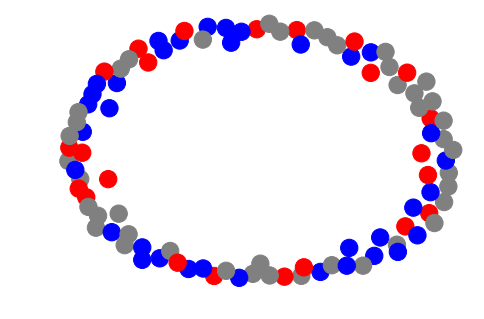

In [11]:
%matplotlib inline
nx.draw(G, node_color=color_map)

#### Add edges by Power law distribution

In [12]:
import numpy as np
import matplotlib.pyplot as plt

In [13]:
edge_list = []
for i in range(100):
    edge_list.append(int((np.random.pareto(a=15)+.1)*30))

(array([45.,  0., 21.,  0., 14.,  0.,  9.,  0.,  4.,  0.,  2.,  0.,  0.,
         0.,  3.,  0.,  0.,  0.,  0.,  2.]),
 array([ 3. ,  3.5,  4. ,  4.5,  5. ,  5.5,  6. ,  6.5,  7. ,  7.5,  8. ,
         8.5,  9. ,  9.5, 10. , 10.5, 11. , 11.5, 12. , 12.5, 13. ]),
 <a list of 20 Patch objects>)

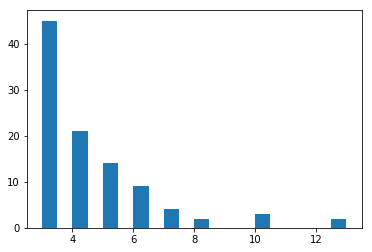

In [14]:
plt.hist(edge_list,bins=20)

In [15]:
from random import sample
for i in range(number_of_users):
    neighbors = sample(users,edge_list[i])
#     print(neighbors)
    for neighbor in neighbors:
      G.add_edge(users[i],neighbor)  

C:\Users\abdal\AppData\Local\conda\conda\envs\simulations\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


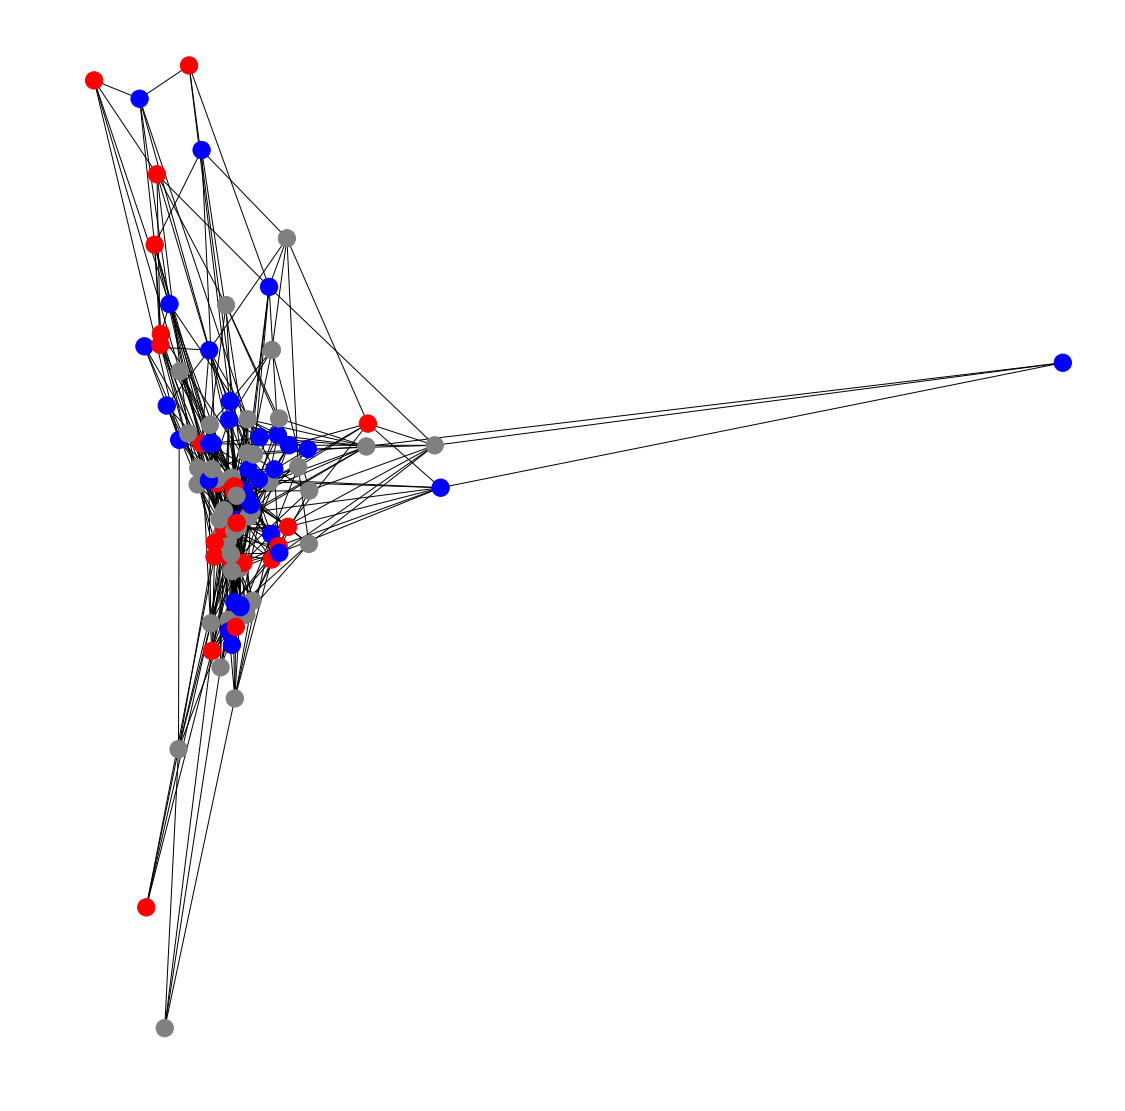

In [16]:
%matplotlib inline
# nx.draw_spectral(G, node_color=color_map)
pos = nx.spectral_layout(G)
plt.figure(1,figsize=(15,15))
nx.draw(G,pos, node_color=color_map)
plt.show()

In [17]:
import collections

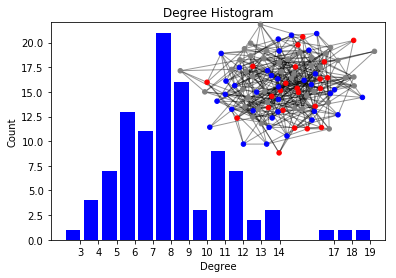

In [18]:
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)  # degree sequence
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())

fig, ax = plt.subplots()
plt.bar(deg, cnt, width=0.80, color="b")
plt.title("Degree Histogram")
plt.ylabel("Count")
plt.xlabel("Degree")
ax.set_xticks([d + 0.4 for d in deg])
ax.set_xticklabels(deg)

# draw graph in inset
plt.axes([0.4, 0.4, 0.5, 0.5])
Gcc = G.subgraph(sorted(nx.connected_components(G), key=len, reverse=True)[0])
pos = nx.spring_layout(G)
plt.axis("off")
nx.draw_networkx_nodes(G, pos, node_size=20, node_color=color_map)
nx.draw_networkx_edges(G, pos, alpha=0.4)
plt.show()

#### Lets spread some news and see how users change their preferences

ticks is another network variable that is used to measure time, it does not mean a specfic time stamp we know at the moment  
For every time step t:  
- Make news events from the news agencies  
- Ask every agent to spread their articles across the network  
- Change the 'regular' user preference and compute overall network preference

In [19]:
news_users = [node for node in list(G.nodes) if node.user_type == 'news_agency']
regular_users = [node for node in list(G.nodes) if node.user_type == 'regular']

In [20]:
def create_news_event (user,sentiment,fake):
    """
    Make a news event
    a. news_article_id
    b. source_id : the id of the source
    c. source_preference : the preference of the source
    d. sentiment : a number from [1,5] or [-5,-1]
    e. num_shares : the number of people sharing the article
    f. fake : 1 if the news is fake, otherwise real
    """
    # assign an id in the format of user id + 1000
    if not user.articles:
        news_id = int(str(user.unique_id)+str(1000))
    else:
        news_id = user.articles[-1].news_article_id +1
    
    # get source_id and source_preference
    source_id = user.unique_id
    source_preference = user.preference
    sentiment = sentiment
    num_shares = 1
    fake = fake
    
    article = NewsArticle(news_id,source_id,source_preference,sentiment,num_shares,fake)
    
    user.articles.append(article)

In [21]:
def get_neighbor_preferences(user):
    """
    Get the average preference of a user's neighbors
    """
    temp = []
    for n in list(G[user]):
#         print(abs(user.preference - n.preference))
        temp.append(n.preference)
    return round(np.mean(temp),2)

In [22]:
def spread_news(user):
    """
    Add the latest news article from a user to their neighbors based on the user preference and sentiment
    """
    community_opinion = get_neighbor_preferences(user)
    if user.articles:
        for neighbor in list(G[user]):
            if user.articles[-1] not in neighbor.articles:
                similarity = 1-((abs(neighbor.preference - user.preference))/2)
                if generate_weighted_percentage(similarity):
                    #both users have similar preferences
                    community_similarity = similarity = 1-((abs(community_opinion - user.preference))/2)
                    if generate_weighted_percentage(community_similarity):
                        # user and community are similar
                        if generate_weighted_percentage(abs(user.articles[-1].sentiment/5)):
#                             print('user '+str(user.unique_id)+' shared '+str(user.articles[-1].news_article_id)+' with '+str(neighbor.unique_id))
                            neighbor.articles.append(user.articles[-1])
                            #update the neighbor's preference
                            if neighbor.preference > user.preference:
                               neighbor.preference -= 0.05 
                            elif neighbor.preference < user.preference:
                               neighbor.preference += 0.05

(array([ 9.,  9.,  8.,  7., 13.,  9.,  8.,  7., 14., 16.]),
 array([-0.99 , -0.791, -0.592, -0.393, -0.194,  0.005,  0.204,  0.403,
         0.602,  0.801,  1.   ]),
 <a list of 10 Patch objects>)

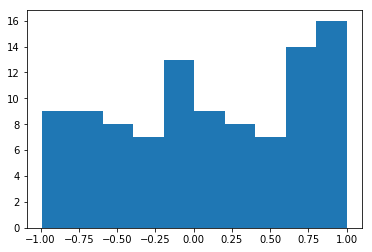

In [23]:
preferences = []
for node in users:
    preferences.append(node.preference)

plt.hist(preferences)

In [24]:
from SimHelper import generate_weighted_sentiment
from random import sample, randint
ticks = 100
for t in range(ticks):
    print('tick number: ',t)
    sampled_news_agencies = sample(news_users,randint(1,len(news_users)-1))
    for n in sampled_news_agencies:
        sentiment = generate_weighted_sentiment()
        create_news_event(n,sentiment,generate_weighted_percentage(abs(sentiment/5)))
        spread_news(n)
    sampled_regular_users = sample(regular_users,randint(1,len(regular_users)-1))
    for u in sampled_regular_users:
        spread_news(u)

tick number:  0
tick number:  1
tick number:  2
tick number:  3
tick number:  4
tick number:  5
tick number:  6
tick number:  7
tick number:  8
tick number:  9
tick number:  10
tick number:  11
tick number:  12
tick number:  13
tick number:  14
tick number:  15
tick number:  16
tick number:  17
tick number:  18
tick number:  19
tick number:  20
tick number:  21
tick number:  22
tick number:  23
tick number:  24
tick number:  25
tick number:  26
tick number:  27
tick number:  28
tick number:  29
tick number:  30
tick number:  31
tick number:  32
tick number:  33
tick number:  34
tick number:  35
tick number:  36
tick number:  37
tick number:  38
tick number:  39
tick number:  40
tick number:  41
tick number:  42
tick number:  43
tick number:  44
tick number:  45
tick number:  46
tick number:  47
tick number:  48
tick number:  49
tick number:  50
tick number:  51
tick number:  52
tick number:  53
tick number:  54
tick number:  55
tick number:  56
tick number:  57
tick number:  58
tick nu

(array([2247., 1727., 1715.,  921.,   31.,    0.,  665., 1784., 1941.,
        2002.]),
 array([-4.98, -3.99, -3.  , -2.01, -1.02, -0.03,  0.96,  1.95,  2.94,
         3.93,  4.92]),
 <a list of 10 Patch objects>)

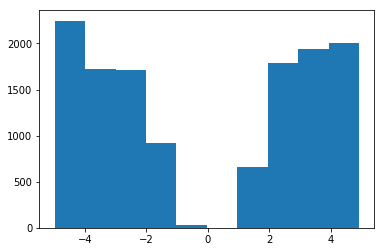

In [25]:
#histogram of all articles being shared
articles = []
for node in list(G.nodes):
    for article in node.articles:
        articles.append(article.sentiment) 

plt.hist(articles)

(array([ 37.,  48.,  76., 124.,   7.,   0., 125., 105.,  56.,  33.]),
 array([-4.98, -3.99, -3.  , -2.01, -1.02, -0.03,  0.96,  1.95,  2.94,
         3.93,  4.92]),
 <a list of 10 Patch objects>)

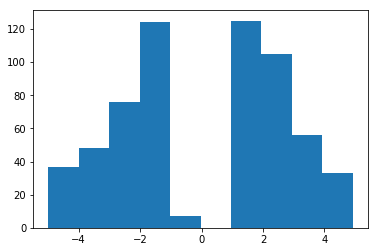

In [26]:
#histogram of UNIQUE articles being shared
articles_unique = []
articles_set = set()
for node in list(G.nodes):
    for article in node.articles:
        if article not in articles_set:
            articles_set.add(article)
            articles_unique.append(article.sentiment) 

plt.hist(articles_unique)

In [27]:
len(articles_unique)

611

In [28]:
len(articles)

13033

(array([ 2.,  1.,  5., 16., 15., 16., 27., 10.,  5.,  3.]),
 array([0.08 , 0.103, 0.126, 0.149, 0.172, 0.195, 0.218, 0.241, 0.264,
        0.287, 0.31 ]),
 <a list of 10 Patch objects>)

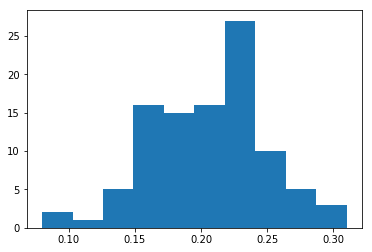

In [29]:
preferences = []
for node in users:
    preferences.append(node.preference)

plt.hist(preferences)